In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap
import sys

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from utils import *

## Loading data

In [2]:
path = ''
df_original = pd.read_csv(path + 'data/adult.data', header=None)
df_original.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
df_original.drop(['fnlwgt'], axis=1, inplace=True)
print(df_original.shape)
df_original.head()

(32561, 14)


,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocessing

In [3]:
columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry', 'Income', 'Race', 'Gender']

for col_cat in columns_cat:
    df_original[col_cat] = df_original[col_cat].str.strip()

In [4]:
df_proces = df_original.copy()

df_proces['Race'] = df_proces['Race'].apply(lambda row: 1 if row == 'White' else 0)
df_proces['Gender'] = df_proces['Gender'].apply(lambda row: 1 if row == 'Male' else 0)
df_proces['Income'] = df_proces['Income'].apply(lambda row: 0 if row == '<=50K' else 1)

columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry']

df_proces = pd.get_dummies(df_proces, columns=columns_cat)
df_proces = df_proces.astype(float)
df_proces.head()

,Age,EducationNum,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income,WorkClass_?,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Never-worked,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,WorkClass_Without-pay,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,Education_Doctorate,Education_HS-grad,Education_Masters,Education_Preschool,Education_Prof-school,Education_Some-college,MaritalStatus_Divorced,MaritalStatus_Married-AF-spouse,MaritalStatus_Married-civ-spouse,MaritalStatus_Married-spouse-absent,MaritalStatus_Never-married,MaritalStatus_Separated,MaritalStatus_Widowed,Occupation_?,Occupation_Adm-clerical,Occupation_Armed-Forces,Occupation_Craft-repair,Occupation_Exec-managerial,Occupation_Farming-fishing,Occupation_Handlers-cleaners,Occupation_Machine-op-inspct,Occupation_Other-service,Occupation_Priv-house-serv,Occupation_Prof-specialty,Occupation_Protective-serv,Occupation_Sales,Occupation_Tech-support,Occupation_Transport-moving,Relationship_Husband,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,NativeCountry_?,NativeCountry_Cambodia,NativeCountry_Canada,NativeCountry_China,NativeCountry_Columbia,NativeCountry_Cuba,NativeCountry_Dominican-Republic,NativeCountry_Ecuador,NativeCountry_El-Salvador,NativeCountry_England,NativeCountry_France,NativeCountry_Germany,NativeCountry_Greece,NativeCountry_Guatemala,NativeCountry_Haiti,NativeCountry_Holand-Netherlands,NativeCountry_Honduras,NativeCountry_Hong,NativeCountry_Hungary,NativeCountry_India,NativeCountry_Iran,NativeCountry_Ireland,NativeCountry_Italy,NativeCountry_Jamaica,NativeCountry_Japan,NativeCountry_Laos,NativeCountry_Mexico,NativeCountry_Nicaragua,NativeCountry_Outlying-US(Guam-USVI-etc),NativeCountry_Peru,NativeCountry_Philippines,NativeCountry_Poland,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,39.0,13.0,1.0,1.0,2174.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50.0,13.0,1.0,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.0,13.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
metadata = {'label_maps': [{0.0: '<=50K', 1.0: '>50K'}], 
            'protected_attribute_maps': [{0.0: 'Non-white', 1.0: 'White'}]}
unprivileged_groups=[{'Race': [0.0]}]
privileged_groups=[{'Race': [1.0]}]
protected_attribute_names = ['Race']
label_names = ['Income']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 2
name_protect = 'Race'

Disparate impact dados originais:  0.4036515960167799


In [6]:
lst_res = []

## Model with original data

In [7]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)   
X_train_orig = scale.transform(dataset_train.features)   
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

### Random Forest

In [8]:
model_orig_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
print('RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_rf, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'rf_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: 

Test accuracy:  0.858941549800389
Train accuracy:  0.8621007371007371
Disparate impact:  0.6412283652947554
Mean difference:  -0.06539187430588203
Average odds difference: 0.002570802476637499
Equality of opportunity: 0.025318987240510404
False discovery rate difference: 0.0060614807331505205
Generalized entropy index: 0.079016497938046
Consistency:  0.9501279557784834


### Gradient Boosting

In [10]:
model_orig_gbm = GradientBoostingClassifier()
model_orig_gbm.fit(X_train_orig, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [11]:
print('RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_gbm, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'gbm_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 

Test accuracy:  0.8692803767018119
Train accuracy:  0.8688136188136188
Disparate impact:  0.6452624433903987
Mean difference:  -0.07147601615214483
Average odds difference: -0.011973256679823414
Equality of opportunity: -0.010231590736370477
False discovery rate difference: 0.05799045915324985
Generalized entropy index: 0.07151119400795128
Consistency:  0.9324802948101134


### Logistic Regression

In [12]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
print('RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_lr, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'lr_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: 

Test accuracy:  0.8520831200737026
Train accuracy:  0.8512636012636012
Disparate impact:  0.5749454313623791
Mean difference:  -0.0915172157874104
Average odds difference: -0.04144151042799692
Equality of opportunity: -0.04885804567817287
False discovery rate difference: 0.018720695331205073
Generalized entropy index: 0.07990232225240083
Consistency:  0.9399529122735184


## Model with transformed data

In [14]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [15]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  3.3306690738754696e-16


In [16]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [17]:
model_transf_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
print('RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_rf, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'rf_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: 

Test accuracy:  0.8606817483877572
Train accuracy:  0.8652158652158652
Disparate impact:  0.6936178226173308
Mean difference:  -0.055290884348043856
Average odds difference: 0.019152419757135497
Equality of opportunity: 0.05094596216151359
False discovery rate difference: 0.03457636595037186
Generalized entropy index: 0.07802824468538362
Consistency:  0.9466066127546323


### Gradient Boosting

In [19]:
model_transf_gbm = GradientBoostingClassifier()
model_transf_gbm.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
print('RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_gbm, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'gbm_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 

Test accuracy:  0.8684614597195209
Train accuracy:  0.8692962442962443
Disparate impact:  0.730849672873087
Mean difference:  -0.05322857604840789
Average odds difference: 0.015811682498334218
Equality of opportunity: 0.03237070517179319
False discovery rate difference: 0.09996104809687978
Generalized entropy index: 0.07206207857105891
Consistency:  0.9334015764151908


### Logistic Regression

In [21]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print('RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_lr, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'lr_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: 

Test accuracy:  0.8511618384686253
Train accuracy:  0.8508687258687259
Disparate impact:  0.8261219565356547
Mean difference:  -0.03566139855744774
Average odds difference: 0.057766199893940905
Equality of opportunity: 0.11623935042598299
False discovery rate difference: 0.08923400643209833
Generalized entropy index: 0.08063810759585055
Consistency:  0.9358173815129491


In [23]:
cols_name = ['dataset', 'name_exp', 'acc_test', 'disp_impact_bin', 'mean_difference',
             'disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)
df_final

,dataset,name_exp,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.858942,0.641228,-0.065392,0.641228,0.002571,0.025319,0.006061,0.079016,0.950128
1,adult,gbm_orig,0.869280,0.645262,-0.071476,0.645262,-0.011973,-0.010232,0.057990,0.071511,0.932480
2,adult,lr_orig,0.852083,0.574945,-0.091517,0.574945,-0.041442,-0.048858,0.018721,0.079902,0.939953
3,adult,rf_transf,0.860682,0.693618,-0.055291,0.693618,0.019152,0.050946,0.034576,0.078028,0.946607
4,adult,gbm_transf,0.868461,0.730850,-0.053229,0.730850,0.015812,0.032371,0.099961,0.072062,0.933402
5,adult,lr_transf,0.851162,0.826122,-0.035661,0.826122,0.057766,0.116239,0.089234,0.080638,0.935817


## SHAP

In [24]:
lst_shape = []

### Random Forest

RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: 



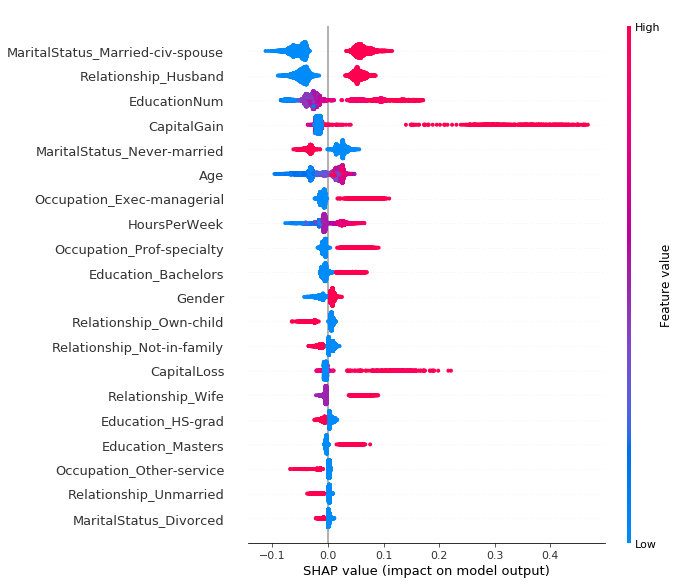

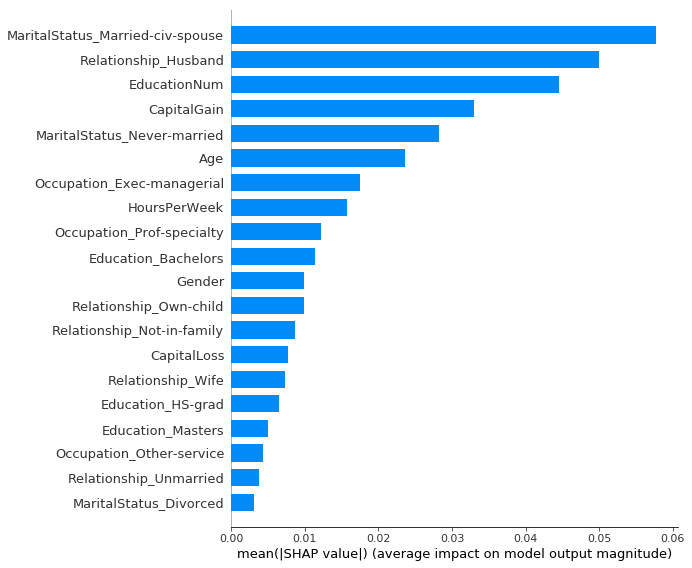

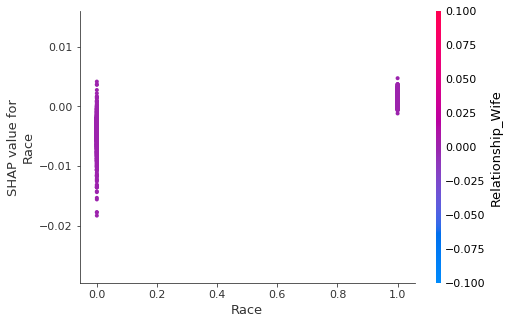

Mean SHAP value unprivileged class:  -0.004091210150644522
Mean SHAP value privileged class:  0.0007676186224579449
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [25]:
print('RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_rf, 'rf_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [26]:
print('Global SHAP values by feature of Random Forest with original data: ')
df_feat

Global SHAP values by feature of Random Forest with original data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,5.779701e-02
1,Relationship_Husband,4.991701e-02
2,EducationNum,4.460040e-02
3,CapitalGain,3.298687e-02
4,MaritalStatus_Never-married,2.825334e-02
5,Age,2.357969e-02
6,Occupation_Exec-managerial,1.749520e-02
7,HoursPerWeek,1.573171e-02
8,Occupation_Prof-specialty,1.213644e-02
9,Education_Bachelors,1.139837e-02


RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: 



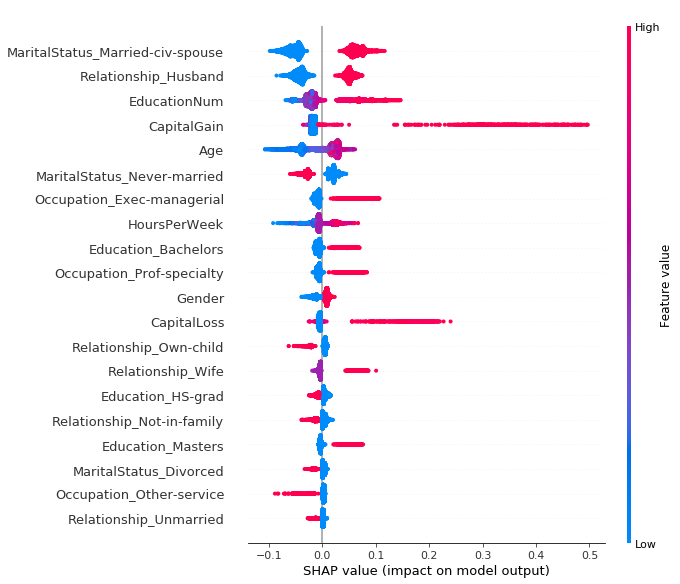

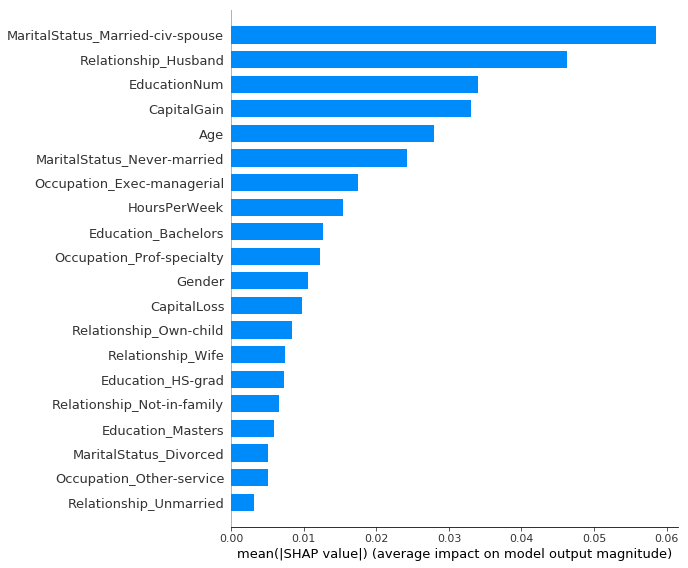

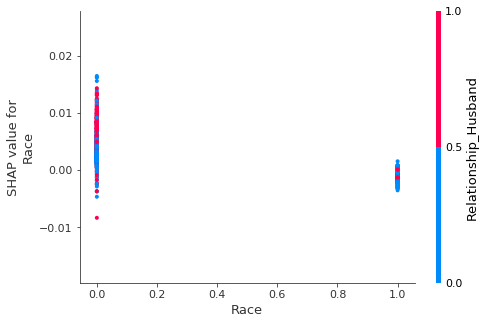

Mean SHAP value unprivileged class:  0.0038585231389402603
Mean SHAP value privileged class:  -0.0005683755325097865
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [27]:
print('RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_rf, 'rf_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [28]:
print('Global SHAP values by feature of Random Forest with transformed data: ')
df_feat

Global SHAP values by feature of Random Forest with transformed data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,5.860998e-02
1,Relationship_Husband,4.632963e-02
2,EducationNum,3.402224e-02
3,CapitalGain,3.306578e-02
4,Age,2.797677e-02
5,MaritalStatus_Never-married,2.424510e-02
6,Occupation_Exec-managerial,1.751697e-02
7,HoursPerWeek,1.535970e-02
8,Education_Bachelors,1.269803e-02
9,Occupation_Prof-specialty,1.216249e-02


### Gradient Boosting

RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 



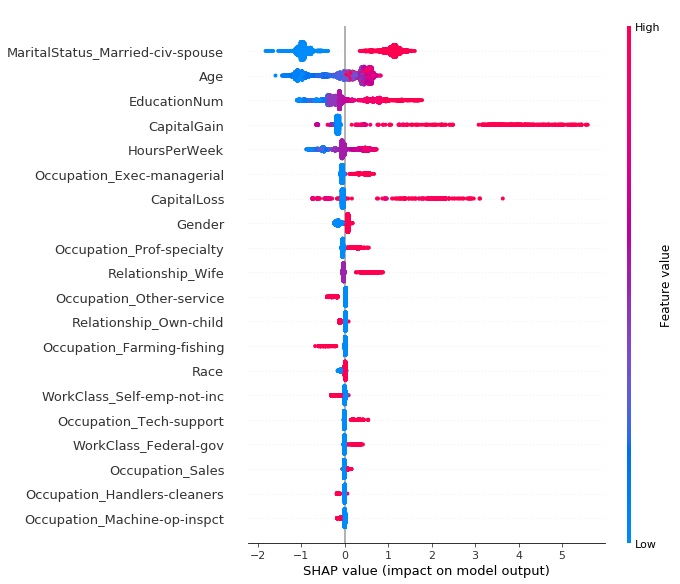

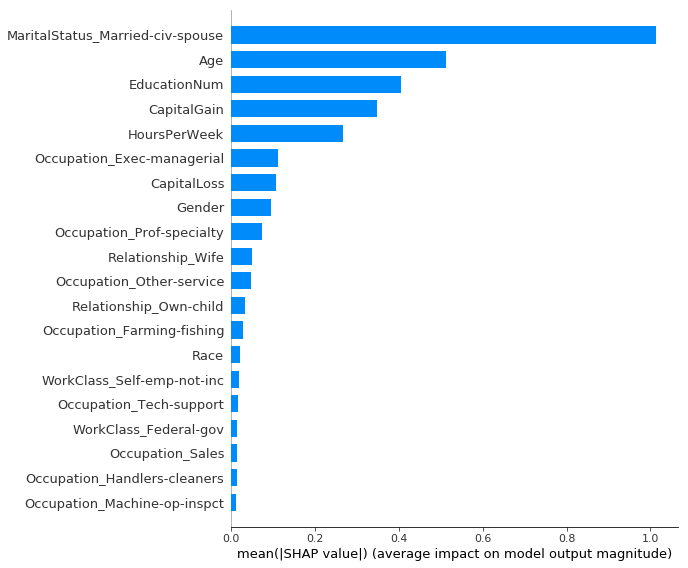

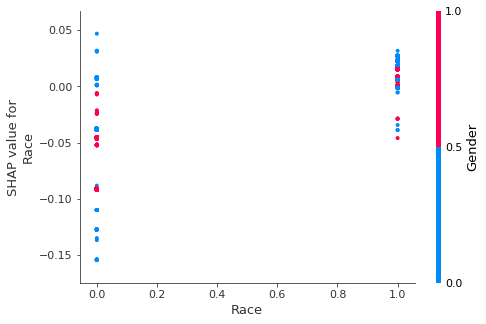

Mean SHAP value unprivileged class:  -0.06484118968338166
Mean SHAP value privileged class:  0.01160785427482733
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [29]:
print('RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_gbm, 'gbm_orig', X_train_orig, 
                                          X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [30]:
print('Global SHAP values by feature of Gradient Boosting with original data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with original data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,1.014658
1,Age,0.511581
2,EducationNum,0.404786
3,CapitalGain,0.348467
4,HoursPerWeek,0.265508
5,Occupation_Exec-managerial,0.111935
6,CapitalLoss,0.105448
7,Gender,0.093556
8,Occupation_Prof-specialty,0.072850
9,Relationship_Wife,0.049999


RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 



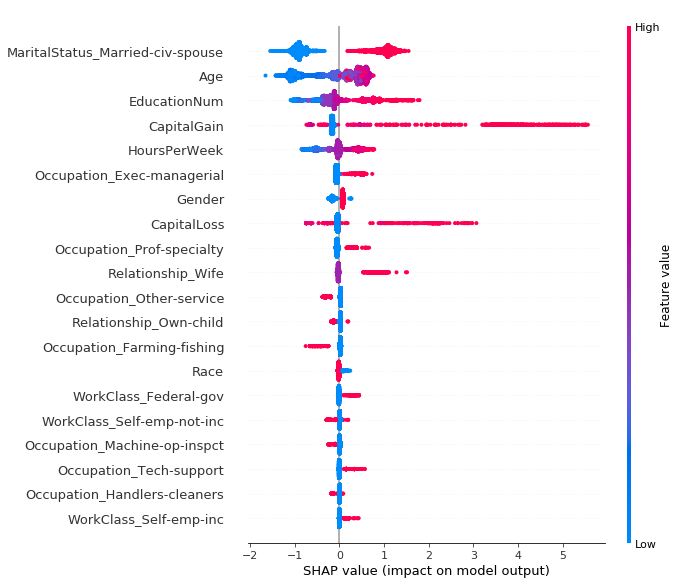

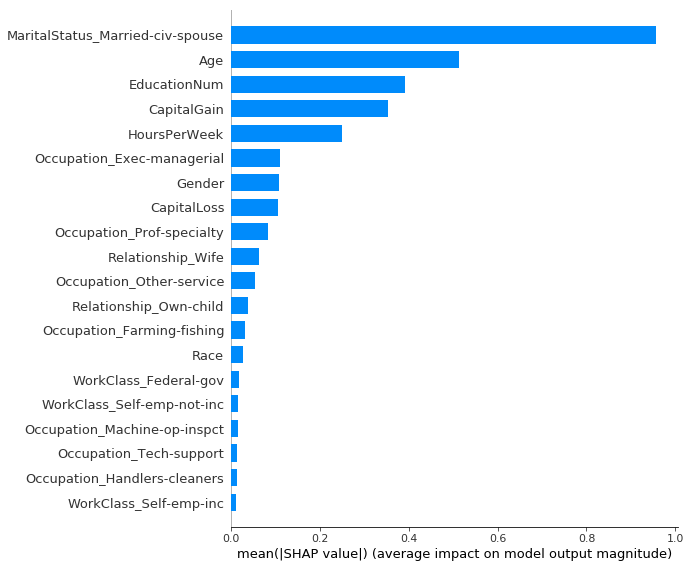

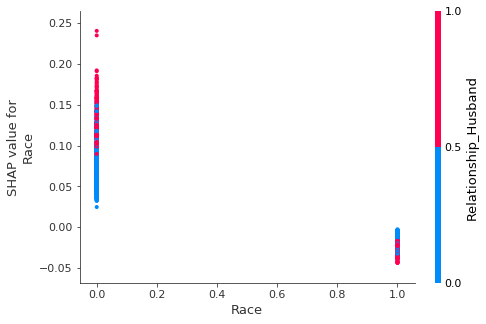

Mean SHAP value unprivileged class:  0.08731134960532957
Mean SHAP value privileged class:  -0.014778005129479624
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [31]:
print('RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_gbm, 'gbm_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [32]:
print('Global SHAP values by feature of Gradient Boosting with transformed data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with transformed data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,0.957705
1,Age,0.513766
2,EducationNum,0.390170
3,CapitalGain,0.353337
4,HoursPerWeek,0.249576
5,Occupation_Exec-managerial,0.108752
6,Gender,0.106956
7,CapitalLoss,0.105580
8,Occupation_Prof-specialty,0.081610
9,Relationship_Wife,0.063345


### Logistic Regression

RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:49<00:00, 20.05it/s]


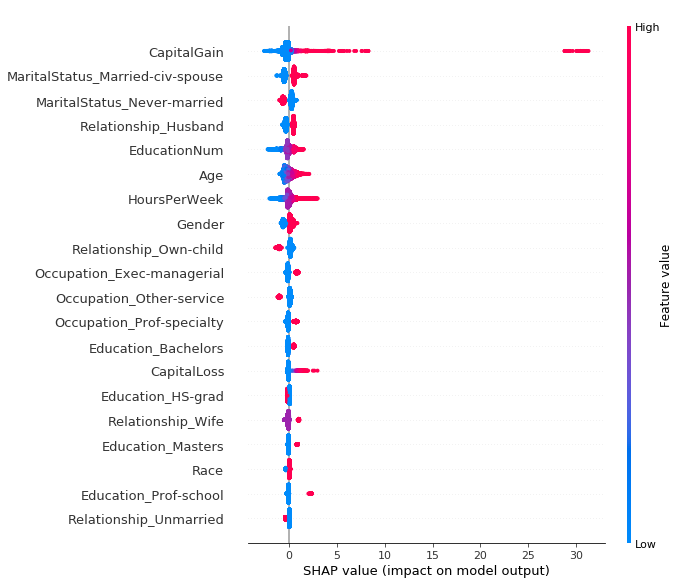

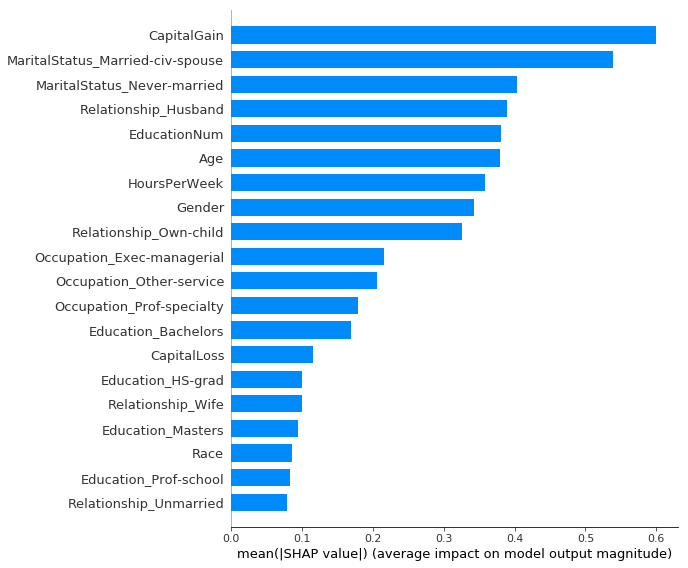

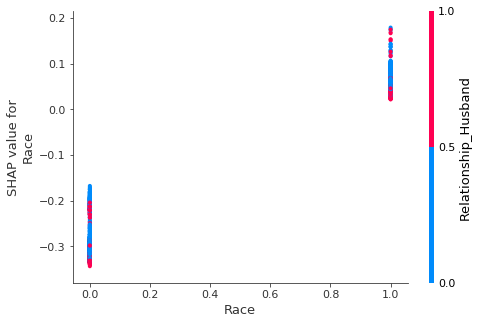

Mean SHAP value unprivileged class:  -0.29155002882247333
Mean SHAP value privileged class:  0.049330570100141365
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [33]:
print('RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_orig_lr, 'lr_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [34]:
print('Global SHAP values by feature of Logistic Regression with original data: ')
df_feat

Global SHAP values by feature of Logistic Regression with original data: 


,feature_names,value
0,CapitalGain,0.600211
1,MaritalStatus_Married-civ-spouse,0.538947
2,MaritalStatus_Never-married,0.403247
3,Relationship_Husband,0.389850
4,EducationNum,0.381080
5,Age,0.378726
6,HoursPerWeek,0.358712
7,Gender,0.342028
8,Relationship_Own-child,0.325748
9,Occupation_Exec-managerial,0.216108


RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:48<00:00, 21.09it/s]


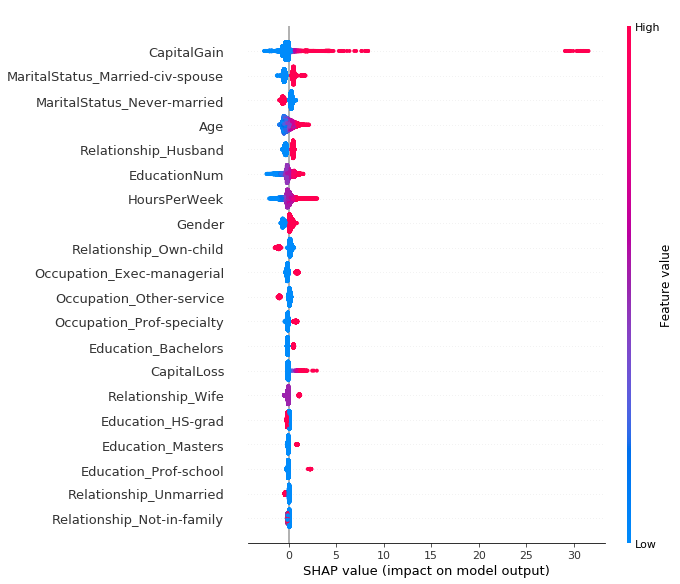

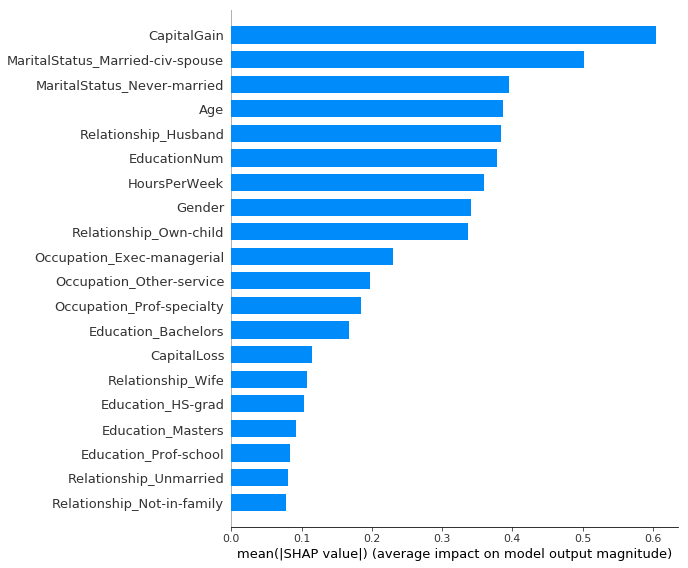

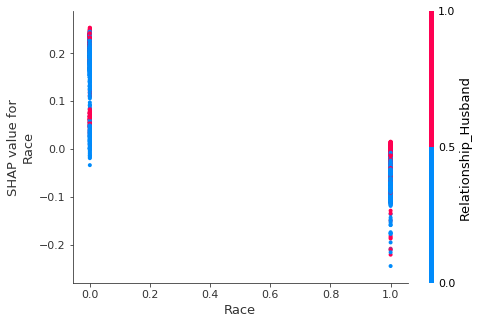

Mean SHAP value unprivileged class:  0.17595716858208574
Mean SHAP value privileged class:  -0.029804123257447895
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [35]:
print('RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_transf_lr, 'lr_transf', X_train_transf, 
                                            X_test_transf, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [36]:
print('Global SHAP values by feature of Logistic Regression with transformed data: ')
df_feat

Global SHAP values by feature of Logistic Regression with transformed data: 


,feature_names,value
0,CapitalGain,0.605114
1,MaritalStatus_Married-civ-spouse,0.502663
2,MaritalStatus_Never-married,0.394551
3,Age,0.386301
4,Relationship_Husband,0.384534
5,EducationNum,0.378613
6,HoursPerWeek,0.359968
7,Gender,0.341452
8,Relationship_Own-child,0.336156
9,Occupation_Exec-managerial,0.230627


### Final result

In [37]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 
                                           'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_orig,0.001268,24,-0.004091,0.000768,1,adult,0.858942,0.641228,-0.065392,0.641228,0.002571,0.025319,0.006061,0.079016,0.950128
1,rf_transf,0.001072,26,0.003859,-0.000568,0,adult,0.860682,0.693618,-0.055291,0.693618,0.019152,0.050946,0.034576,0.078028,0.946607
2,gbm_orig,0.019709,13,-0.064841,0.011608,1,adult,0.869280,0.645262,-0.071476,0.645262,-0.011973,-0.010232,0.057990,0.071511,0.932480
3,gbm_transf,0.025514,13,0.087311,-0.014778,0,adult,0.868461,0.730850,-0.053229,0.730850,0.015812,0.032371,0.099961,0.072062,0.933402
4,lr_orig,0.085184,17,-0.291550,0.049331,1,adult,0.852083,0.574945,-0.091517,0.574945,-0.041442,-0.048858,0.018721,0.079902,0.939953
5,lr_transf,0.051597,28,0.175957,-0.029804,0,adult,0.851162,0.826122,-0.035661,0.826122,0.057766,0.116239,0.089234,0.080638,0.935817


In [38]:
df_final.to_csv(path + 'result/resultado_adult.csv')